In [1]:
!pip install gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [2]:
import pandas as pd # pandas kütüphanesini içe aktar ve 'pd' olarak kısalt
import matplotlib.pyplot as plt # matplotlib.pyplot kütüphanesini içe aktar ve 'plt' olarak kısalt
pd.set_option('display.max_colwidth', None) # DataFrame'deki sütun genişliği için maksimum karakter sayısını sınırsız yap
pd.set_option('display.max_columns', None) # DataFrame'deki görüntülenecek maksimum sütun sayısını sınırsız yap
pd.set_option('display.width', 200) # Konsol çıktısının genişliğini ayarla
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Ondalıklı sayıları 2 basamaklı olarak biçimlendir

## 📚 **Corpus**

Doğal dil işleme (Natural Language Processing – NLP) çalışmalarında **corpus**, analiz edilen metinlerin bütününü ifade eder.  
Corpus, araştırmacının incelemek istediği belirli bir dilsel bağlam veya içerik alanına ait belgelerin, yazıların ya da konuşmaların sistemli şekilde derlenmiş hâlidir.  

**Örnekler:**
- Bir yazarın tüm kitapları  
- Wikipedia maddeleri  
- Belirli bir web sitesindeki makaleler veya blog yazıları  

🔎 **Not:**  
- "Corpus" kelimesinin çoğul hali **corpora** şeklindedir.  
- Bir corpus, NLP uygulamalarında modelin öğrenmesi için temel veri kaynağını oluşturur.

## 🔡 **Word Embeddings: Word2Vec ve GloVe**

Doğal dil işleme çalışmalarında **Word2Vec**, kelimelerin sayısal uzayda **vektörler** ile temsil edilmesini sağlayan önemli bir yöntemdir.  

### One-Hot Representation ve Sınırlılıkları
- Kelimeler, **one-hot vektörler** (örneğin `[0,0,1,0,...]`) ile temsil edilebilir.  
- Ancak bu gösterim, **kelimeler arası benzerliği** yakalayamaz.  
- "kedi" ve "köpek" gibi benzer anlamlara sahip kelimeler, one-hot vektörlerde tamamen bağımsız boyutlarda bulunur.  

### Word2Vec ile Vektör Temsili
- Her kelime için bir vektör oluşturulur.  
- Bu vektörler, kelimeler arasındaki **anlamsal bilgiyi** saklar.  
- Benzer kelimeler, **vektör uzayında birbirine yakın** konumlanır.  

### Dağıtımsal Anlam Teorisi
Word2Vec ve GloVe yöntemleri, **Dağıtımsal Anlam Teorisi** (Distributional Semantics) üzerine kuruludur:  
> Bir kelimenin anlamı, bulunduğu **bağlamdaki diğer kelimelerden** öğrenilebilir.  

---

### ⚙️ **Temel Yöntemler**

#### 1. **Word2Vec**
- Kelimelerin **bağlamlarına göre** (yakınındaki kelimelerle birlikte) anlamını öğrenir.  
- İki temel mimarisi vardır:  
  - **CBOW (Continuous Bag of Words):** Bağlamdan hedef kelimeyi tahmin eder.  
  - **Skip-Gram:** Hedef kelimeden bağlamı tahmin eder.  

#### 2. **GloVe (Global Vectors for Word Representation)**
- **Kelime çiftlerinin birlikte görülme olasılıkları** üzerinden global bir istatistiksel model kurar.  
- Büyük boyutlu bir **co-occurrence (birlikte bulunma)** matrisini faktörize eder.  
- Böylece kelimeler arasındaki **global bağlam bilgisi** vektörlerde kodlanmış olur.  

---

### 🎯 Karşılaştırma
- **Word2Vec:** Yerel bağlama (yakın kelimelere) odaklanır.  
- **GloVe:** Global istatistiksel bilgiyi (tüm corpus’taki birlikte bulunma oranlarını) dikkate alır.  

Her iki yöntem de kelimeleri vektörlere dönüştürerek **örnek temelli öğrenme** ve **bağlam ilişkilerini modelleme** amacı taşır; ancak farklı öğrenme stratejileri kullanır.  


# Word2vec

In [3]:
# Not: Kelimelerin etrafındaki diğer kelimeler, o kelimenin anlamını temsil edebilir.
# Yani kelimeleri sayılar (vektörler) ile temsil ettiğimizde, birbirine yakın olan vektörler benzer anlamlı kelimeleri gösterebilir.

from sklearn.manifold import TSNE
# sklearn kütüphanesinden TSNE (t-dağılımlı Stokastik Komşuluk Gömme) fonksiyonunu içe aktarıyoruz.
# TSNE, yüksek boyutlu verileri (örneğin kelime vektörlerini) 2D veya 3D düzleme indirerek görselleştirmeye yarar.

# hürriyetteki haberler:
df = open('/content/hurriyet.txt', 'r', encoding='utf8')
# open() fonksiyonu ile 'hurriyet.txt' adlı metin dosyasını açıyoruz.
# 'r' parametresi dosyayı okuma modunda açmamızı sağlar.
# encoding='utf8' Türkçe karakterlerin doğru okunabilmesi için kullanılır.

In [4]:
text = df.read()
# read() fonksiyonu dosyanın içindeki tüm veriyi 'text' değişkenine yükler.
# Yani tüm haberler artık 'text' içinde uzun bir string (metin) olarak tutuluyor.

In [5]:
t_list = text.split('\n')
# split('\n') ile metni satırlara ayırıyoruz.
# Böylece her satır (örneğin her haber ya da cümle) t_list listesine ayrı bir eleman olarak ekleniyor.

In [7]:
corpus = []
# corpus adında boş bir liste oluşturuyoruz.
# Bu liste, cümleleri kelimelerine ayrılmış şekilde depolayacak.

In [8]:
for cumle in t_list:
    corpus.append(cumle.split())
    # Her bir satırdaki (cümledeki) kelimeleri split() ile boşluklardan ayırıyoruz.
    # Bu işlem sonucunda ['Bugün', 'hava', 'güzel'] gibi kelime listeleri oluşuyor.
    # corpus listesine bu kelime listelerini ekliyoruz.
    # Yani corpus, "liste içinde liste" yapısında olacak:
    # [['Bugün', 'hava', 'güzel'], ['Ekonomi', 'yükselişte'], ...]

## 🛠️ `simple_preprocess`

Doğal dil işleme (NLP) çalışmalarında kullanılan **`gensim.utils.simple_preprocess`** fonksiyonu, metinleri temizleyip tokenlere (kelime parçacıklarına) ayırmak için sıklıkla tercih edilir.  

### 🔎 Fonksiyonun Özellikleri
- Metni **küçük harfe** dönüştürür.  
- **Noktalama işaretlerini** kaldırır.  
- **Sayıları ve özel karakterleri** temizler.  
- Belirli uzunlukta kelimeleri alır  
  - Varsayılan: **2–15 harf** uzunluğundaki kelimeler.  
- Metni **token’lara** (kelime listesine) ayırır.  

### 📌 Örnek Kullanım
```python
from gensim.utils import simple_preprocess

text = "Merhaba! Bu, NLP için bir #örnek 123 metindir."
tokens = simple_preprocess(text)
print(tokens)

In [9]:
cleaned_cumle = [simple_preprocess(sentence)for sentence in t_list]
cleaned_cumle

[['iran',
  'devlet',
  'televizyonu',
  'ülkedeki',
  'eyaletin',
  'sinde',
  'yapılan',
  'reformcuları',
  'protesto',
  'amaçlı',
  'yürüyüşlere',
  'milyonlarca',
  'kişinin',
  'katıldığını',
  'bildirdi'],
 ['gösterilerde',
  'fitnecilere',
  'ölüm',
  'münafıklara',
  'ölüm',
  'abd',
  'ye',
  'ölüm',
  'ingiltere',
  'ye',
  'ölüm',
  'sloganları',
  'atıldı'],
 ['dini',
  'lider',
  'ali',
  'hamaney',
  've',
  'cumhurbaşkanı',
  'mahmud',
  'ahmedinejad',
  'destekleyen',
  'iranlılar',
  'son',
  'olaylarda',
  'yeğeni',
  'öldürülen',
  'mir',
  'hüseyin',
  'musevi',
  'başta',
  'olmak',
  'üzere',
  'muhalefet',
  'liderlerini',
  'kınadılar'],
 ['musevi', 'ye', 'ölüm', 've', 'idam', 'idam', 'sloganları', 'duyuldu'],
 ['muhalefet',
  'liderleri',
  'kaçtı',
  'mı',
  'aşure',
  'günü',
  'yaşanan',
  'çatışmalarda',
  'devlet',
  'kaynaklarına',
  'göre',
  'terörist',
  'olmak',
  'üzere',
  'kişi',
  'ölmüştü'],
 ['den',
  'fazla',
  'kişinin',
  'yaralandığı',
  '

In [10]:
print(cleaned_cumle[:10])

[['iran', 'devlet', 'televizyonu', 'ülkedeki', 'eyaletin', 'sinde', 'yapılan', 'reformcuları', 'protesto', 'amaçlı', 'yürüyüşlere', 'milyonlarca', 'kişinin', 'katıldığını', 'bildirdi'], ['gösterilerde', 'fitnecilere', 'ölüm', 'münafıklara', 'ölüm', 'abd', 'ye', 'ölüm', 'ingiltere', 'ye', 'ölüm', 'sloganları', 'atıldı'], ['dini', 'lider', 'ali', 'hamaney', 've', 'cumhurbaşkanı', 'mahmud', 'ahmedinejad', 'destekleyen', 'iranlılar', 'son', 'olaylarda', 'yeğeni', 'öldürülen', 'mir', 'hüseyin', 'musevi', 'başta', 'olmak', 'üzere', 'muhalefet', 'liderlerini', 'kınadılar'], ['musevi', 'ye', 'ölüm', 've', 'idam', 'idam', 'sloganları', 'duyuldu'], ['muhalefet', 'liderleri', 'kaçtı', 'mı', 'aşure', 'günü', 'yaşanan', 'çatışmalarda', 'devlet', 'kaynaklarına', 'göre', 'terörist', 'olmak', 'üzere', 'kişi', 'ölmüştü'], ['den', 'fazla', 'kişinin', 'yaralandığı', 'olaylar', 'sırasında', 'en', 'az', 'kişi', 'tutuklanmıştı'], ['öte', 'yandan', 'iran', 'haber', 'ajansı', 'irna', 'muhalif', 'liderler', 'm

In [11]:
# "cleaned_cumle" isimli değişkende, önceden temizlenmiş cümlelerimiz var.
# Bu cümleleri Word2Vec modeline vererek, kelimelerin sayısal (vektör) temsillerini oluşturacağız.
# Vektörler, kelimeler arasındaki anlamsal benzerlikleri (örneğin "kral" ~ "kraliçe") yansıtabilir.

Word2vec_model = Word2Vec(
    sentences=cleaned_cumle,   # Girdi olarak kelimelere ayrılmış cümleleri alıyor
    vector_size=100,           # Her kelime 100 boyutlu bir sayı vektörü ile temsil edilecek
    window=5,                  # Bir kelimeyi öğrenirken, sağdan ve soldan 5 kelime bağlam olarak dikkate alınacak
    min_count=5,               # Corpus içinde en az 5 kez geçen kelimeler modele dahil edilecek
    sg=1                       # sg=1 → Skip-Gram yöntemi kullanılır
                               # sg=0 olsaydı → CBOW (Continuous Bag of Words) yöntemi kullanılırdı
)

## 🧠 Word2Vec Mimarıları: CBOW ve Skip-Gram

Word2Vec algoritması, kelimeleri **vektör uzayında** temsil etmek için iki temel mimari kullanır: **CBOW** ve **Skip-gram**.  

---

### 🔹 CBOW (Continuous Bag of Words)
- **Amaç:** Çevredeki kelimeleri (**context**) kullanarak hedef kelimeyi tahmin eder.  
- **Avantajları:**  
  - Daha hızlıdır.  
  - Küçük veri setlerinde etkili sonuçlar verir.  
- **Örnek:**  
  - Cümle: *“Kedi süt içiyor”*  
  - Bağlam (context): *[kedi, içiyor]*  
  - Hedef (target): *süt*  

---

### 🔹 Skip-Gram
- **Amaç:** Verilen bir kelimeden, çevresindeki kelimeleri tahmin eder.  
- **Avantajları:**  
  - Nadir (seyrek) kelimeler için daha başarılıdır.  
  - Büyük veri setlerinde daha iyi sonuçlar üretir.  
- **Örnek:**  
  - Cümle: *“Kedi süt içiyor”*  
  - Hedef (target): *süt*  
  - Bağlam (context): *[kedi, içiyor]*  

---

### 🎯 Karşılaştırma
- **CBOW:** Hızlı, küçük veri setlerinde uygun, sık görülen kelimelerde iyi.  
- **Skip-Gram:** Daha yavaş, ancak nadir kelimeler ve büyük corpus’larda daha başarılı.  

In [12]:
# .wv özelliği, eğitilmiş Word2Vec modelinin "kelime vektörlerini" (word vectors) tutar.
# Yani her kelimenin sayısal temsiline buradan ulaşırız.

# Örneğin "ankara" kelimesinin vektörünü çağırıyoruz:
Word2vec_model.wv['ankara']

# Çıktı: 100 boyutlu bir vektör (çünkü modelde vector_size=100 seçmiştik).
# Bu vektör şöyle bir sayı dizisi olacak (örnek):
# array([ 0.012, -0.034, 0.078, ..., -0.056])
# Her sayı, "ankara" kelimesinin anlamını sayısal uzayda bir eksen üzerinde temsil eder.

array([ 0.02845206,  0.503354  , -0.22155254, -0.67719656,  0.55146015,
       -0.3180006 ,  0.20641613,  0.46428153, -0.47503427, -0.09733783,
       -0.05082089, -0.36999476, -0.10295787, -0.16292745,  0.22779648,
        0.23688427,  0.72570664, -0.1507148 , -0.96147656, -0.90298444,
       -0.3021462 ,  0.54089904, -0.06310517, -0.12676026,  0.12611893,
       -0.2839338 , -0.2541843 , -0.22980224,  0.03472398,  0.11327336,
        0.39946058,  0.25685328,  0.4195686 , -0.07684073, -0.16161048,
        0.2193842 , -0.19713037, -0.34959662,  0.2095697 , -0.58333457,
        0.4157193 , -0.2763144 , -0.10985024,  0.08166302,  0.02772969,
       -0.58262366, -0.37670553,  0.14365026, -0.03703157,  0.41645914,
       -0.23544787, -0.12765144,  0.16658446,  0.07719702, -0.1528529 ,
        0.4086079 , -0.14148887, -0.17780106, -0.13407339, -0.2879371 ,
        0.09261525, -0.3225526 ,  0.1173846 ,  0.16288064,  0.44318584,
        0.14453268,  0.1335454 ,  0.2717193 , -0.67451286,  0.46

In [13]:
# most_similar() fonksiyonu, bir kelimeye en çok benzeyen diğer kelimeleri bulur.
# Burada benzerlik, vektörler arasındaki "kosinüs benzerliği" ölçüsüne göre hesaplanır.

# "ankara" kelimesine en çok benzeyen ilk 10 kelimeyi getirelim:
Word2vec_model.wv.most_similar('ankara', topn=10)

# Çıktı, şöyle bir liste olur:
# [('istanbul', 0.87), ('izmir', 0.81), ('eskişehir', 0.79), ...]
# Buradaki 0.xx değerleri, benzerlik skorudur (1'e ne kadar yakınsa o kadar benzer).

[('washington', 0.7208757996559143),
 ('karlov', 0.711492121219635),
 ('baily', 0.70626300573349),
 ('maslahatgüzarı', 0.697924017906189),
 ('gaby', 0.6922387480735779),
 ('paçacı', 0.6908566951751709),
 ('çağrılmıştı', 0.6901565790176392),
 ('temsilciliğine', 0.6842807531356812),
 ('moskova', 0.6830278635025024),
 ('kaymakçı', 0.6821234226226807)]

In [14]:
# "hollanda" kelimesine en çok benzeyen 10 kelimeyi bulalım.
# Yine most_similar fonksiyonunu kullanıyoruz.
# Benzerlikler, kelime vektörleri arasındaki kosinüs benzerliğine göre ölçülür.

Word2vec_model.wv.most_similar('hollanda', topn=10)

# Çıktı, şu formda olur:
# [('almanya', 0.84), ('belçika', 0.81), ('fransa', 0.79), ...]
# Buradaki sayılar, benzerlik skorlarıdır (0 ile 1 arasında).

[('danimarka', 0.8037834763526917),
 ('belçika', 0.7995167374610901),
 ('avusturya', 0.7953385710716248),
 ('kanada', 0.7799175381660461),
 ('finlandiya', 0.7738327980041504),
 ('almanya', 0.7701987028121948),
 ('ispanya', 0.7517932653427124),
 ('avustralya', 0.7461855411529541),
 ('estonya', 0.7423365712165833),
 ('letonya', 0.7298974990844727)]

In [15]:
# Analojik sorgular (analogy queries), Word2Vec'in en güçlü taraflarından biridir.
# Amaç: "A, B ile nasıl ilişkiliyse; C de ? ile öyledir." şeklinde düşünmektir.

# Burada sorulan soru şudur:
# woman : man = ? : son
# yani "kadın, erkek ile nasıl ilişkiliyse; ? de oğul ile öyledir."

result = Word2vec_model.wv.most_similar(
    positive=['woman', 'son'],   # Olumlu (eklenecek) kelimeler
    negative=['man'],            # Çıkarılacak kelime
    topn=1                       # En benzer 1 sonucu getir
)

print(result)

# Çıktı genellikle şöyle bir şey olabilir:
# [('daughter', 0.89)]
# Yorum: "Kadın, erkeğin karşılığıysa → oğlun karşılığı da kızdır."


[('önümüzdeki', 0.6301471590995789)]


In [16]:
# ---- Word2Vec Modelinin Kaydedilmesi ----
# Eğitilen modeli diske kaydedelim.
# Böylece her seferinde yeniden eğitmek zorunda kalmayız.

Word2vec_model.save("word2vec.model")


# ---- Word2Vec Modelinin Yüklenmesi ----
# Daha sonra ihtiyacımız olduğunda, kaydedilen modeli geri çağırabiliriz.
# Bu sayede doğrudan eğitilmiş vektörleri kullanmaya devam ederiz.

Word2vec_model = Word2Vec.load("word2vec.model")

# 🌐 Word2Vec Görselleştirme

Eğitilen Word2Vec modelindeki kelime vektörlerini görselleştirerek, kelimeler arasındaki **anlamsal yakınlıkların** nasıl ortaya çıktığını inceleyebiliriz.  
Bu tür görselleştirmeler, kelimelerin yüksek boyutlu vektör uzayındaki konumlarını 2B ya da 3B düzlemde anlamamıza yardımcı olur.  

---

## 🔎 Kullanılan Teknikler
- **t-SNE (t-distributed Stochastic Neighbor Embedding):**  
  Yüksek boyutlu vektörleri 2 veya 3 boyuta indirger, benzer vektörlerin görsel olarak yakın konumlanmasını sağlar.  

- **PCA (Principal Component Analysis):**  
  Boyut indirgeme için daha hızlı, deterministik bir yöntemdir. Genel eğilimleri göstermek için kullanılır.  

---

## 📌 Örnek Python Kodu
```python
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Örnek: Eğitilmiş Word2Vec modelinden kelime vektörlerini alalım
words = list(model.wv.index_to_key[:200])  # İlk 200 kelimeyi seçelim
word_vectors = model.wv[words]

# Boyut indirgeme (önce PCA ile hızlandırma, sonra t-SNE)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(pca_result)

# Görselleştirme
plt.figure(figsize=(14, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)

for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_result[i, 0], tsne_result[i, 1]))

plt.title("Word2Vec Kelime Vektörleri Görselleştirme (t-SNE)")
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def closestwords_tsneplot(
    model,
    word,
    topn=10,                 # Kaç benzer kelime çizileceği
    random_state=42,         # t-SNE tekrarlanabilirlik için sabit rasgelelik
    figsize=(10, 8),         # Şekil boyutu (inç)
    dpi=160,                 # Çözünürlük
    savepath=None            # Dosyaya kaydetmek isterseniz yol (örn. 'ankara_tsne.png')
):
    """
    Amaç:
      Verilen bir 'word' için Word2Vec modelinden en benzer 'topn' kelimeyi alıp,
      bu kelimelerin (ve hedef kelimenin) vektörlerini t-SNE ile 2B'ye indirger ve
      pastel tonlarda, açıklayıcı bir görselleştirme üretir.

    Parametre Açıklamaları:
      - model: Gensim Word2Vec modeli (eğitilmiş olmalı)
      - word: Hedef kelime (model sözlüğünde bulunmalı)
      - topn: Listelenecek benzer kelime sayısı
      - random_state: t-SNE rastgelelik başlangıcı (aynı sonuç için sabit)
      - figsize, dpi: Görselin boyutu ve çözünürlüğü
      - savepath: Verilirse görsel yüksek çözünürlükte diske kaydedilir
    """
    # --- Güvenlik/Hata Kontrolleri ---
    # Kelimenin modelde mevcut olup olmadığını kontrol ediyoruz.
    if word not in model.wv.key_to_index:
        raise KeyError(f"'{word}' kelimesi model sözlüğünde bulunamadı.")

    # Modelin vektör boyutunu otomatik algılayalım (ör. 100 ise 100).
    vec_size = model.wv.vector_size

    # --- Vektörleri ve Etiketleri Hazırlama ---
    # Boş bir matris ile başlayıp, hedef kelimenin vektörünü ilk satıra ekleyeceğiz.
    word_vectors = np.empty((0, vec_size))
    word_labels = [word]

    # Hedef kelimeye benzer kelimeleri getiriyoruz.
    # (most_similar, varsayılan olarak kosinüs benzerliğini kullanır.)
    close_words = model.wv.most_similar(word, topn=topn)

    # Hedef kelime vektörünü ekleyelim (ilk nokta: hedef kelime).
    word_vectors = np.append(word_vectors, np.array([model.wv[word]]), axis=0)

    # Benzer kelimeleri ve vektörlerini ekleyelim.
    for w, _ in close_words:
        word_labels.append(w)
        word_vectors = np.append(word_vectors, np.array([model.wv[w]]), axis=0)

    # --- t-SNE ile Boyut Azaltma ---
    # Perplexity, veri sayısından büyük olmamalı. Tipik aralık: 5–50.
    # Nokta sayımız = 1 (hedef) + topn (benzerler)
    n_points = len(word_labels)
    # En az 5, en çok 30 seviyesinde, veri sayısına göre güvenli bir değer seçelim.
    perplexity = max(5, min(30, n_points - 1))

    tsne = TSNE(
        n_components=2,        # 2 boyuta indiriyoruz (görselleştirme için ideal)
        random_state=random_state,
        perplexity=perplexity,
        init='pca',            # Stabilite için PCA başlangıcı
        learning_rate='auto'   # sklearn >=1.2'de otomatik ayar faydalı
    )
    Y = tsne.fit_transform(word_vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # --- Profesyonel Pastel Stil Ayarları ---
    # Pastel bir palet (manuel): ana kelime için vurgulu pastel, diğerleri için çeşit.
    pastel_palette = [
        "#AEC6CF", "#FFB347", "#B39EB5", "#77DD77", "#FF6961",
        "#FDFD96", "#CFCFC4", "#F49AC2", "#B3E5FC", "#C1E1C1",
        "#F6D5E5", "#E2F0CB", "#FDE2E4", "#CDE7F0", "#E8DFF5"
    ]
    # Ana kelime rengi (biraz daha koyu pastel)
    main_color = "#6FA8DC"

    # Şekli oluşturalım
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Izgara ve eksen stilini sadeleştirelim (soft/pro pastel estetik)
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)
    for spine in ax.spines.values():
        spine.set_alpha(0.3)  # Çerçeve çizgilerini yumuşat

    # Noktaları çizelim: İlk nokta hedef kelime, diğerleri benzerler
    # Hedef kelimeyi daha büyük ve kenarlıklı çizelim.
    ax.scatter(
        x_coords[0], y_coords[0],
        s=160,                 # boyut
        c=main_color,          # pastel vurgu
        edgecolors='white',    # beyaz kenar
        linewidths=1.5,
        alpha=0.95,
        zorder=3,
        label=f"Hedef: {word}"
    )

    # Diğer noktaları dağıtalım (pastel renkleri döngüyle ata)
    for i in range(1, n_points):
        ax.scatter(
            x_coords[i], y_coords[i],
            s=90,
            c=pastel_palette[(i-1) % len(pastel_palette)],
            edgecolors='white',
            linewidths=1.2,
            alpha=0.9,
            zorder=2
        )

    # Etiketleri okunabilir kılmak için kutu (bbox) ekleyelim.
    # Hedef kelime için daha belirgin kutu, diğerleri için yumuşak kutular.
    # Küçük bir ofset ile çakışmayı azaltalım.
    for (label, x, y), idx in zip(zip(word_labels, x_coords, y_coords), range(n_points)):
        if idx == 0:
            bbox_props = dict(boxstyle='round,pad=0.25', facecolor='#E3F2FD', edgecolor='white', alpha=0.95)
            ax.annotate(
                label, xy=(x, y), xytext=(6, -2), textcoords='offset points',
                fontsize=11, fontweight='bold', color='#0D47A1', bbox=bbox_props, zorder=4
            )
        else:
            bbox_props = dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='#E0E0E0', alpha=0.85)
            ax.annotate(
                label, xy=(x, y), xytext=(6, -2), textcoords='offset points',
                fontsize=10, color='#37474F', bbox=bbox_props, zorder=3
            )

    # Başlık ve açıklamalar (üst başlık + alt başlık gibi)
    title = f"t-SNE ile Kelime Vektörleri: '{word}' ve En Yakın {topn} Komşusu"
    subtitle = "Pastel temalı, açıklayıcı görselleştirme • Benzerlik: Word2Vec (cosine)"
    fig.suptitle(title, y=0.98, fontsize=14, fontweight='bold', color='#263238')
    ax.set_title(subtitle, fontsize=11, color='#455A64', pad=10)

    # Eksen etiketleri sade ve açıklayıcı
    ax.set_xlabel("t-SNE Bileşen 1", fontsize=10, color='#546E7A')
    ax.set_ylabel("t-SNE Bileşen 2", fontsize=10, color='#546E7A')

    # Efsane (legend) şık dursun
    leg = ax.legend(frameon=True, loc='best')
    leg.get_frame().set_edgecolor('#E0E0E0')
    leg.get_frame().set_alpha(0.9)

    # Noktalar kadraj dışında kalmasın diye ufak bir boşluk ekleyelim
    x_pad = (x_coords.max() - x_coords.min()) * 0.08 if n_points > 1 else 1.0
    y_pad = (y_coords.max() - y_coords.min()) * 0.08 if n_points > 1 else 1.0
    ax.set_xlim(x_coords.min() - x_pad, x_coords.max() + x_pad)
    ax.set_ylim(y_coords.min() - y_pad, y_coords.max() + y_pad)

    # Sıkı yerleşim
    plt.tight_layout()

    # Kaydetme opsiyonu (yüksek çözünürlük, saydam arkaplan seçeneği)
    if savepath is not None:
        plt.savefig(savepath, dpi=max(dpi, 300), bbox_inches='tight')
        print(f"Görsel kaydedildi: {savepath}")

    # Göster
    plt.show()

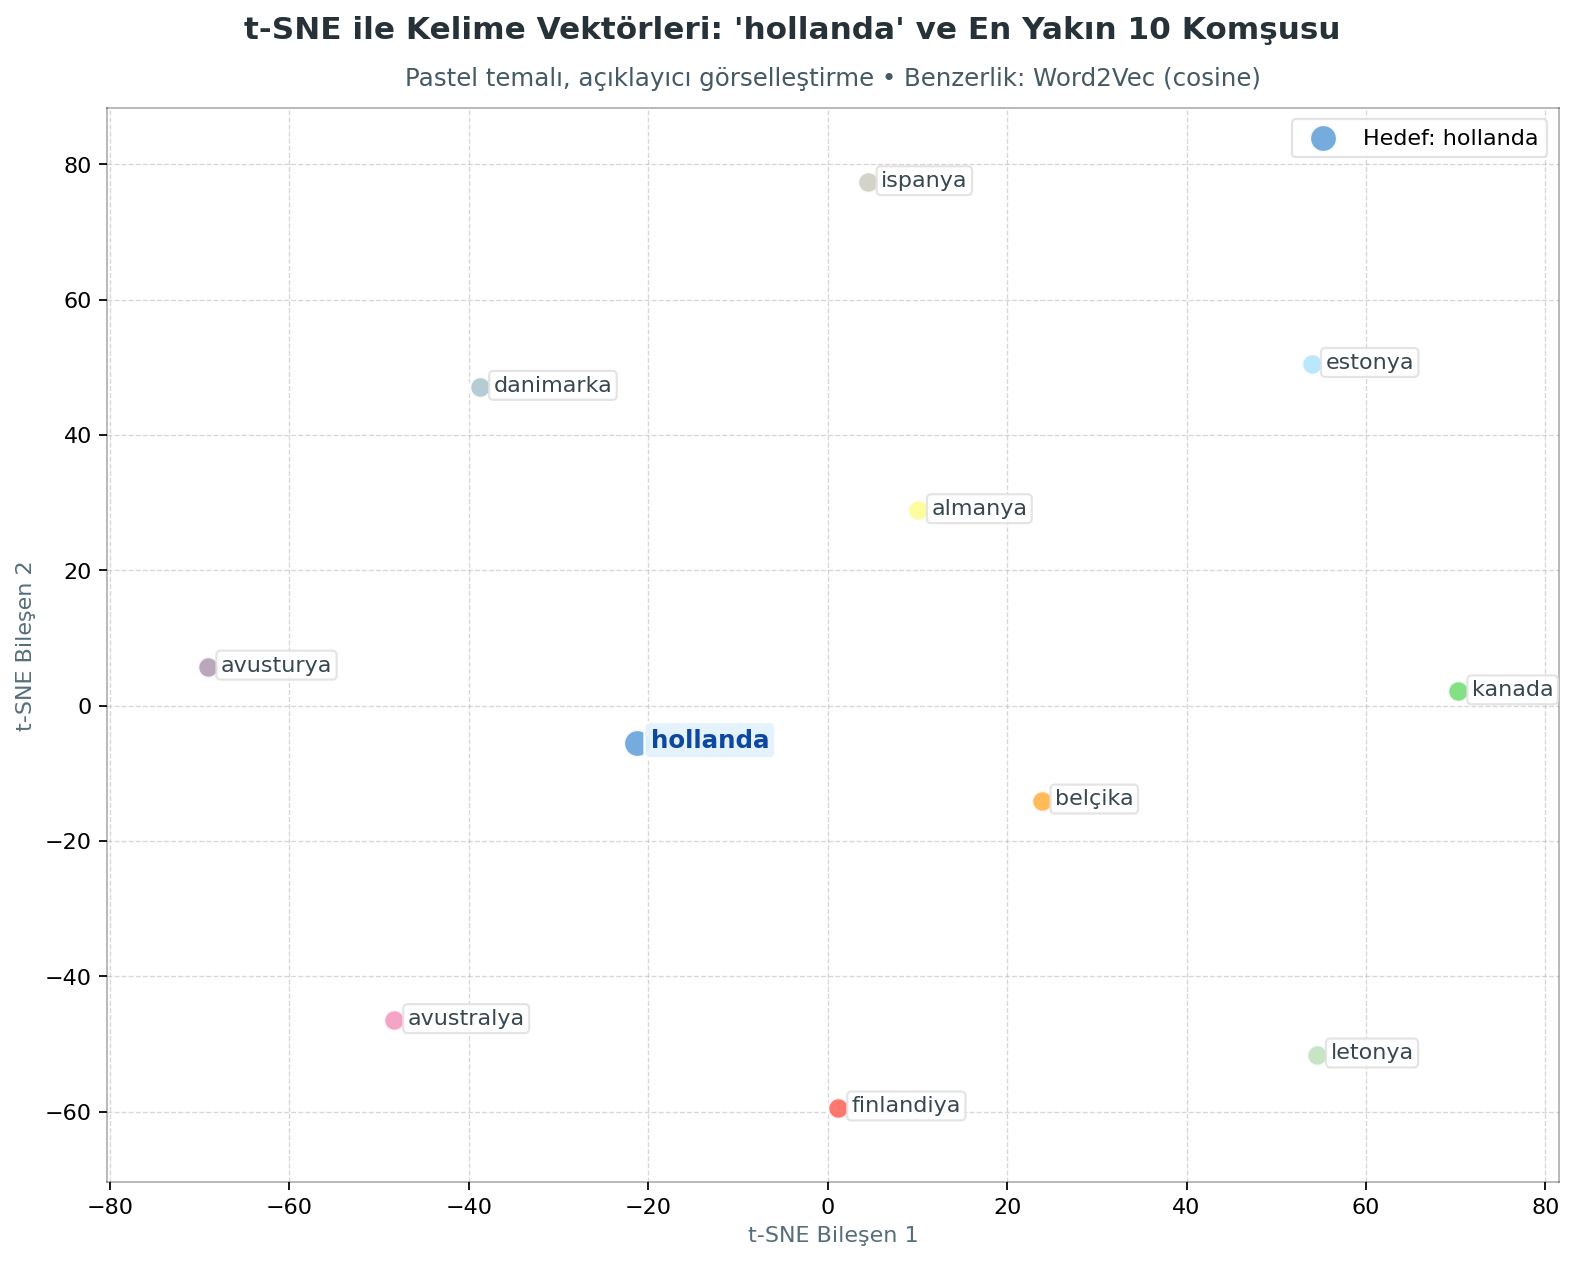

In [20]:
closestwords_tsneplot(Word2vec_model,'hollanda')

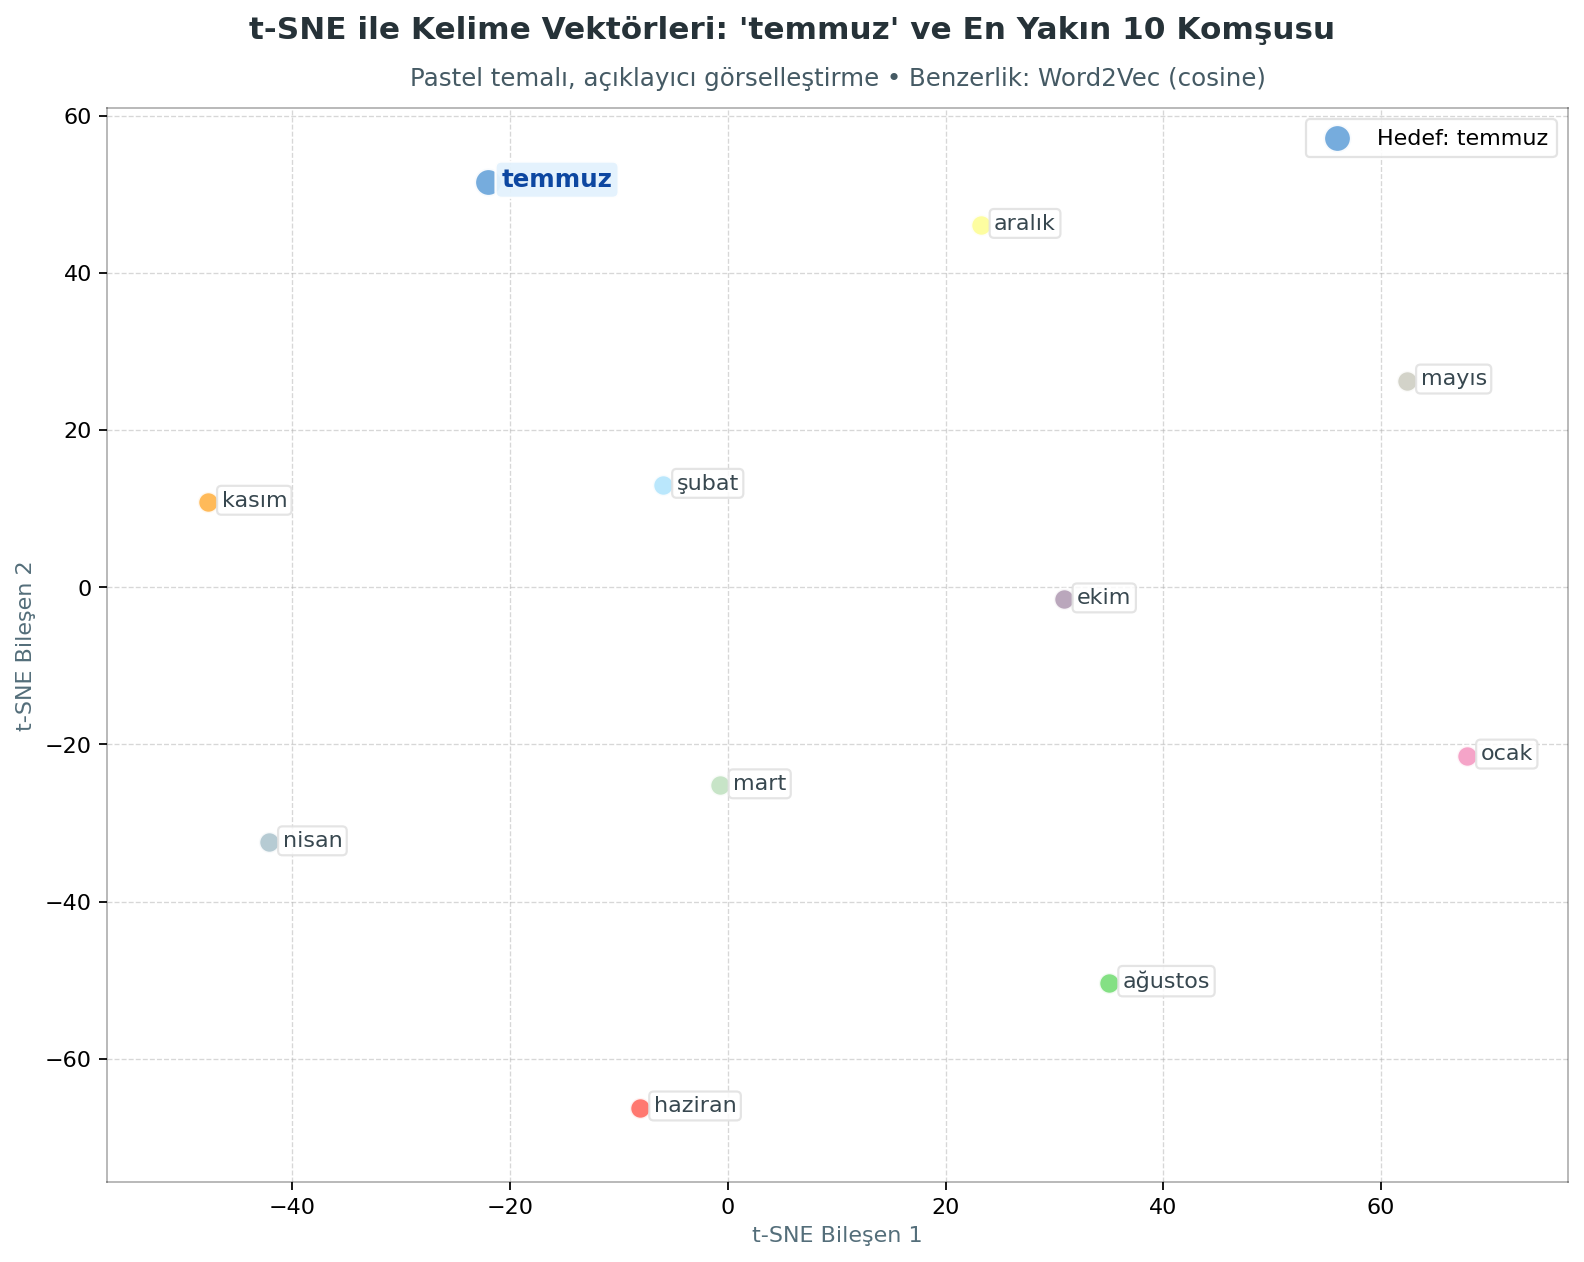

In [22]:
closestwords_tsneplot(Word2vec_model,'temmuz')

# 🔡 GloVe (Global Vectors for Word Representation)

**GloVe**, kelimelerin **dağıtımsal istatistiklerine** dayalı olarak geliştirilen bir kelime gömme (word embedding) yöntemidir.  
Kelime sayma (count-based) yaklaşımını kullanarak, corpus üzerinde pencere tabanlı **co-occurrence (birlikte bulunma)** matrisleri oluşturur ve bu matrislerin faktörizasyonu ile kelime vektörlerini üretir.  

---

## 📊 Özellikleri
- **Kelime sayma yöntemleri** ile pencereye dayalı matris oluşturur.  
- Küçük corpuslarda **iyi performans** sergiler.  
- Vektörler, kelime çiftlerinin **birlikte görülme olasılıklarına** göre öğrenilir.  
- Word2Vec’ten farklı olarak **global bağlam bilgisini** dikkate alır.  

---

## ⚖️ Word2Vec ve GloVe Arasındaki Format Farkları
- **GloVe:**  
  - Genellikle **düz metin dosyası** (ör. `.txt`) olarak paylaşılır.  
  - Doğrudan `gensim` gibi kütüphaneler tarafından okunmaz.  

- **Word2Vec:**  
  - **Binary** ya da **metin tabanlı** formatta bulunabilir.  
  - `gensim` gibi araçlar tarafından **doğrudan desteklenir**.  

➡️ Bu nedenle GloVe vektörleri, Word2Vec formatına dönüştürülerek bu araçlarla kullanılabilir.  

---

## ⚙️ Kullanım Notları
- **GloVe**, doğrudan Python kütüphanesi olarak gelmez.  
- Genellikle **önceden eğitilmiş vektörler** (ör. Stanford’un sağladığı `glove.6B.txt` dosyaları) indirilerek kullanılır.  
- `gensim` ile entegrasyon için dönüştürme gerekir:  

```python
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# GloVe dosyasını Word2Vec formatına dönüştür
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Modeli yükle
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Örnek: En yakın kelimeleri bulma
print(model.most_similar('king'))


In [23]:
# Glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [24]:
# ---- GloVe ile eğitilmiş Wikipedia verisi ----
# glove_input değişkeni: GloVe modelinden alınan hazır vektör dosyası.
# Bu dosyada her satır şu yapıda:
# "kelime  v1  v2  v3 ... v100"
# Yani bir kelimenin 100 boyutlu sayısal vektör temsili var.

glove_input = '/content/glove.6B.100d.txt'
# 6B = 6 milyar kelimelik corpus (Wikipedia + Gigaword)
# 100d = her kelime için 100 boyutlu vektör

word2vec_output = 'glove.6B.100d.word2vec'
# Çıkış dosyası adı. GloVe formatı Word2Vec kütüphanesiyle birebir uyumlu olmadığı için,
# bu dosyayı dönüştürüp Word2Vec'in anlayacağı formata yazacağız.

# ---- GloVe → Word2Vec dönüşümü ----
# gensim kütüphanesi "glove2word2vec" fonksiyonunu sağlar.
# Bu fonksiyon, GloVe vektörlerini Word2Vec'in okuyabileceği şekilde çevirir.
# (Yani header ekler: kelime sayısı ve vektör boyutu bilgisini yazar.)

from gensim.scripts.glove2word2vec import glove2word2vec

glove2word2vec(glove_input, word2vec_output)
# Bu işlem sonucunda:
#  - Toplam 42,766 kelime (Wikipedia + Gigaword corpus'tan)
#  - Her biri 100 boyutlu vektör
# Word2Vec formatında saklanır.

/tmp/ipython-input-1616889966.py:22: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input, word2vec_output)


(400000, 100)

In [25]:
# ---- GloVe modelini Word2Vec formatında yükleme ----
# Artık dönüştürülmüş dosyayı KeyedVectors ile okuyabiliriz.
# KeyedVectors: yalnızca kelime vektörlerini tutan hafif bir yapı.
# (Eğitim yapmaz, sadece hazır vektörleri yükler.)

from gensim.models import KeyedVectors

glove_model = KeyedVectors.load_word2vec_format(
    word2vec_output,  # GloVe → Word2Vec formatına dönüştürdüğümüz dosya
    binary=False      # Dosya metin (txt) formatında olduğu için False
)

# Artık glove_model üzerinden kelime vektörlerine erişebiliriz.

In [26]:
# ankara kelimesine benzer kelimeleri getirsin:

glove_model.most_similar('ankara')

[('turkey', 0.7512096166610718),
 ('istanbul', 0.6787630319595337),
 ('turkish', 0.6690374612808228),
 ('damascus', 0.6372509002685547),
 ('tbilisi', 0.6322181820869446),
 ('erdogan', 0.6258037090301514),
 ('moscow', 0.6217040419578552),
 ('brussels', 0.6181437969207764),
 ('skopje', 0.6164302229881287),
 ('cyprus', 0.606403112411499)]

In [27]:
glove_model.most_similar(positive=['woman', 'son'], negative=['man'], topn=1)
# dili ne kadar anladığını test etmek için bakılabilir.

[('daughter', 0.9090957641601562)]

In [28]:
# ülkeler ve ülkeler arası başkentlerin ilişkisini test edelim:
glove_model.most_similar(positive=['bangkok', 'germany'], negative=['berlin'], topn=1)

[('thailand', 0.8427271246910095)]

# 🤔 Hangisi Daha İyi? Word2Vec mi, GloVe mu?

Bu sorunun kesin bir cevabı yoktur; seçim **çalışılacak veriye ve araştırma amacına** bağlıdır.  

---

## 🔹 Word2Vec
- **Bağlama dayalı kelime ilişkilerini** daha iyi analiz eder.  
- Örneğin, *“book”* ile *“read”* gibi **bağlamsal ilişkiler** arıyorsanız Word2Vec genellikle daha başarılıdır.  
- Küçük ve bağlama özgü veri kümelerinde tercih edilir.  

---

## 🔹 GloVe
- **Global ölçekte kelime ilişkilerini** modellemek için uygundur.  
- Analojiler ve genel kelime benzerliklerinde daha başarılıdır.  
  - Örneğin: *“Paris” – “France” + “Italy” = “Rome”*  
- Büyük ve genel veri kümelerinde daha iyi performans gösterir.  

---

## 🎯 Özet
- **Küçük & bağlama özgü corpus →** ✅ Word2Vec  
- **Büyük & genel corpus →** ✅ GloVe  

> Hangisinin daha iyi olduğu, **çalışmanın bağlamında gizlidir**. Doğru seçim, veri kümesinin niteliğine ve çözülmek istenen probleme göre yapılmalıdır.

# **Vektörlerin Benzerlik Ölçümleri**

# 📏 Euclidean Distance (Öklid Mesafesi)

**Öklid mesafesi (Euclidean distance)**, iki nokta veya vektör arasındaki **doğrusal (doğru çizgi) mesafeyi** ölçmek için kullanılan en temel yöntemlerden biridir.  
Matematikte, iki nokta arasındaki **en kısa mesafe** olarak tanımlanır.  

---

## 🔹 Matematiksel Tanım
İki vektör $x = (x_1, x_2, ..., x_n)$ ve $y = (y_1, y_2, ..., y_n)$ arasındaki Öklid mesafesi:

\[
d(x, y) = \sqrt{ \sum_{i=1}^{n} (x_i - y_i)^2 }
\]

---

## 🔹 NLP Bağlamında Kullanımı
- Kelimeler veya belgeler **vektörlerle temsil edildiğinde**, aralarındaki **benzerliği** ölçmek için kullanılabilir.  
- Mesafe **küçüldükçe**, iki kelime ya da belgenin **birbirine daha benzer** olduğu yorumu yapılır.  

---

## 📌 Örnek Python Kodu
```python
import numpy as np
from numpy.linalg import norm

# İki vektör tanımlayalım
vec1 = np.array([1, 2, 3])
vec2 = np.array([4, 5, 6])

# Euclidean distance
euclidean_distance = norm(vec1 - vec2)
print("Euclidean Distance:", euclidean_distance)


In [30]:
# ---- Noktalar arası mesafe hesaplama ----

# 3-4-5 üçgenini düşünelim (Pisagor üçgeni).
# İlk nokta (0,0) → orijin
point1 = np.array([0, 0])

# İkinci nokta (3,4) → x=3, y=4 koordinatı
point2 = np.array([3, 4])

# İki nokta arasındaki Öklid mesafesi (Euclidean Distance):
# np.linalg.norm → vektörün normunu (uzunluğunu) hesaplar.
# Burada point2 - point1 = [3, 4] vektörü
# Norm([3, 4]) = √(3² + 4²) = 5
distance = np.linalg.norm(point2 - point1)

print("Öklid Mesafesi:", distance)

Öklid Mesafesi: 5.0


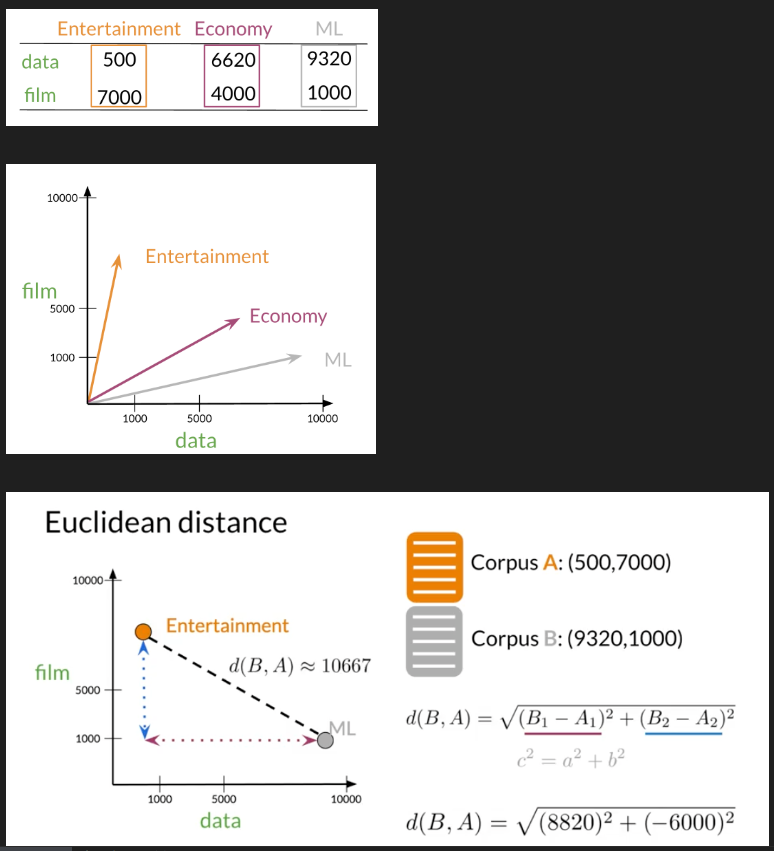

In [31]:
import numpy as np
from scipy.spatial.distance import euclidean

# ---- İki vektör arasındaki Öklid mesafesi ----

# Örneğin iki farklı "corpus" (metin koleksiyonu) için sayısal özelliklerimiz var:
# vector_corpusA = [500, 7000]
# vector_corpusB = [9320, 1000]
# Bunlar her corpus'un iki boyutlu özelliklerini temsil ediyor olabilir.
# (örneğin: [kelime sayısı, cümle uzunluğu] gibi)

vector_corpusA = np.array([500, 7000])
vector_corpusB = np.array([9320, 1000])

# Öklid mesafesini hesaplamak için scipy'nin euclidean() fonksiyonunu kullanıyoruz.
# Formül:
# d = √((x2 - x1)² + (y2 - y1)²)

distance = euclidean(vector_corpusA, vector_corpusB)

# Sonucu ekrana yazdıralım
print("Euclidean Distance (corpusA ve corpusB):", distance)


Euclidean Distance (corpusA ve corpusB): 10667.35206131306


In [32]:
import numpy as np
from scipy.spatial.distance import euclidean

# ---- İki corpus arasındaki mesafe (ML ve Economy) ----

# vector_corpusC: Örneğin "Machine Learning" (ML) ile ilgili corpus'un özellikleri
# vector_corpusB: Örneğin "Economy" ile ilgili corpus'un özellikleri
# Her vektör iki boyutlu bir temsil (ör: [kelime sayısı, ortalama cümle uzunluğu])

vector_corpusC = np.array([6620, 4000])
vector_corpusB = np.array([9320, 1000])

# Öklid mesafesini (Euclidean Distance) hesaplıyoruz.
# Formül: d = √((x2 - x1)² + (y2 - y1)²)
distance = euclidean(vector_corpusC, vector_corpusB)

# Sonucu ekrana yazdıralım
print("Euclidean Distance (corpusC ve corpusB):", distance)

Euclidean Distance (corpusC ve corpusB): 4036.087214122113


## 📊 **Euclidean Distance (Öklid Uzaklığı) Değer Aralığı**

- **0’a yakın değerler:**  
  İki vektör (kelime ya da belge) birbirine oldukça benzerdir.  
  > Örnek: *“kitap”* ve *“defter”* gibi benzer bağlama sahip kelimeler.  

- **Büyük değerler:**  
  Vektörler arasındaki mesafe fazladır; kelimelerin ya da belgelerin bağlamları birbirinden oldukça uzaktır.  
  > Örnek: *“kitap”* ve *“uçak”* gibi farklı kavramlar.  

---

### 🎯 Yorum
- Euclidean Distance, benzerlik yerine **mutlak uzaklık** ölçtüğü için,  
  - **Küçük değerler → yüksek benzerlik**  
  - **Büyük değerler → düşük benzerlik**  
- Bu nedenle özellikle kelime gömme (word embeddings) uzayında, iki kelime arasındaki **anlamsal yakınlığı ölçmek** için kullanılabilir.  

# 📐 Cosine Similarity (Kosinüs Benzerliği)

**Cosine Similarity**, iki vektör arasındaki açının kosinüsünü ölçer.  
- Eğer vektörler birbirine **yakın yönlere sahipse**, aralarındaki açı küçülür ve kosinüs değeri **1’e yaklaşır**.  
- Eğer vektörler birbirine **dik** (90°) ise, kosinüs değeri **0’a yaklaşır**.  
- Eğer vektörler tamamen zıt yönlere sahipse, kosinüs değeri **-1** olur.  

---

## 🔹 Matematiksel Tanım
İki vektör $x$ ve $y$ arasındaki kosinüs benzerliği:

\[
\text{cosine\_similarity}(x,y) = \frac{x \cdot y}{\|x\|\|y\|}
\]

Burada:  
- $x \cdot y$ → Vektörlerin noktasal çarpımı (dot product)  
- $\|x\|$ ve $\|y\|$ → Vektörlerin normları (uzunlukları)  

---

## 🔹 NLP Bağlamında Kullanımı
- Corpus’tan elde edilen kelime ya da belge vektörlerinin **yönlerini karşılaştırmak** için kullanılır.  
- Euclidean Distance, **vektörlerin büyüklüklerinden** etkilenirken, Cosine Similarity yalnızca **vektörlerin yönünü** dikkate alır.  
- Bu nedenle metin madenciliği ve bilgi erişimi uygulamalarında **daha kararlı** bir benzerlik ölçüsüdür.  

---

## 📌 Örnek Python Kodu
```python
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Örnek vektörler
vec1 = np.array([[1, 2, 3]])
vec2 = np.array([[4, 5, 6]])

# Cosine similarity
cos_sim = cosine_similarity(vec1, vec2)
print("Cosine Similarity:", cos_sim[0][0])

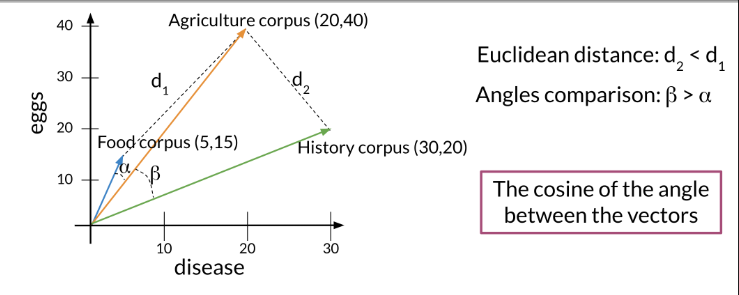

## 📊 Euclidean Distance vs Cosine Similarity Örneği

Normalde **gıda corpus’u** ile **tarım corpus’u** anlamsal olarak birbirine daha benzerdir.  
Ancak pratikte şu durum gözlemlenebilir:  

- Gıda corpus’u, tarım corpus’una göre **daha küçük boyutludur**.  
- **Tarih corpus’u** ile tarım corpus’u aslında daha farklı içeriklere sahiptir,  
  fakat boyut farkından dolayı **Öklid mesafesi daha küçük** çıkabilir.  

---

### 🎯 Yorum
Bu gibi durumlarda:  
- **Euclidean Distance**, vektörlerin **büyüklüklerinden** etkilendiği için yanıltıcı sonuçlar verebilir.  
- **Cosine Similarity**, yalnızca vektörlerin **yönlerini** dikkate aldığı için, gerçek anlamsal benzerliği daha doğru yansıtır.  

➡️ Yani corpus büyüklüklerinin farklılık gösterdiği senaryolarda, **Cosine Similarity kullanmak daha anlamlıdır.**


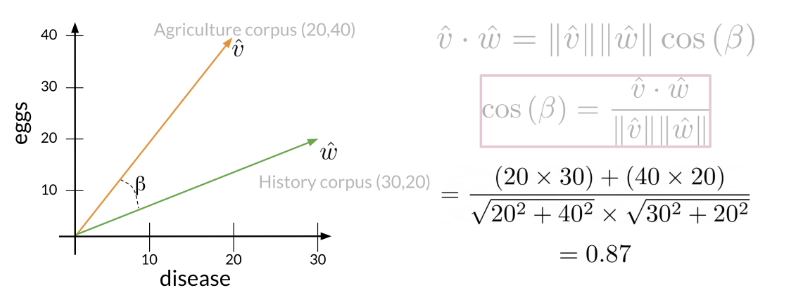

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ---- Vektörler ----
# Her corpus'u (tarım, tarih, yemek) iki boyutlu bir vektörle temsil ediyoruz.
# Buradaki sayılar örnek özellikler olabilir (örn: [kelime sayısı, kavram sıklığı]).

vector_agric = np.array([20, 40]).reshape(1, -1)   # Tarım (agriculture)
vector_hist  = np.array([30, 20]).reshape(1, -1)   # Tarih (history)
vector_food  = np.array([5, 15]).reshape(1, -1)    # Yemek (food)

# ---- Cosine Similarity Hesaplama ----
# Cosine Similarity = (A · B) / (||A|| * ||B||)
# Yani iki vektör arasındaki açıyı ölçer.
# 1'e yakın → çok benzer (aynı yönde)
# 0'a yakın → benzer değil (dik açı)
# -1'e yakın → zıt yönde

cos_sim_agric_hist = cosine_similarity(vector_agric, vector_hist)[0][0]
cos_sim_agric_food = cosine_similarity(vector_agric, vector_food)[0][0]
cos_sim_hist_food  = cosine_similarity(vector_hist, vector_food)[0][0]

# ---- Sonuçları Yazdırma ----
print("Cosine Similarity (agric ve hist):", cos_sim_agric_hist)
print("Cosine Similarity (agric ve food):", cos_sim_agric_food)
print("Cosine Similarity (hist ve food):", cos_sim_hist_food)

Cosine Similarity (agric ve hist): 0.8682431421244592
Cosine Similarity (agric ve food): 0.9899494936611665
Cosine Similarity (hist ve food): 0.7893522173763263


## 📐 **Cosine Similarity (Kosinüs Benzerliği) Değer Aralığı**

Cosine Similarity, iki vektör arasındaki açının kosinüsünü ölçer.  
Değer aralığı kullanılan bağlama göre değişebilir:  

- **[0, 1] aralığı:** Genellikle metin benzerliği uygulamalarında kullanılır.  
- **[−1, 1] aralığı:** Matematiksel olarak tüm değer aralığıdır.  

---

### 🔹 Yorumlar
- **1 →** İki kelime vektörü aynı yöndedir (**tamamen benzer**).  
- **0 →** İki kelime vektörü arasında ilişki yoktur.  
- **−1 →** İki kelime vektörü tamamen zıttır (**zıt anlamlı**).  

---

### 🔹 Örnek Senaryolar

#### ✅ Benzer Kelimeler
- **Yüksek cosine similarity (∼0.8 − 1.0)**  
- **Düşük Euclidean distance**  
- Bu kelimeler aynı bağlamda sıkça birlikte kullanılır.  
- **Örnek:** *“elma”* ve *“armut”*  

---

#### ⚖️ Farklı Kelimeler
- **Düşük cosine similarity (∼0 − 0.3)**  
- **Yüksek Euclidean distance**  
- Bu kelimeler farklı bağlamlarda kullanılır.  
- **Örnek:** *“araba”* ve *“muz”*  

---

#### ❌ Çok Zıt Kelimeler (Negatif Cosine Similarity)
- **Cosine similarity < 0** ise, kelimeler zıt anlamlıdır veya tamamen zıt bağlamlarda yer alır.  
- **Örnek:** *“iyi”* ve *“kötü”*  

---

### 🎯 Genel Değerlendirme
- **Cosine Similarity** → Vektörlerin yönünü ölçer.  
- **Euclidean Distance** → Vektörlerin büyüklüğü ile birlikte mesafeyi ölçer.  

Bu nedenle metin madenciliği ve kelime gömme uygulamalarında **cosine similarity**, anlamsal benzerliği daha doğru yansıtmak için daha sık tercih edilir.  

# **Word2Vec ile Cosine Similarity & Euclidean Distance Hesaplama**

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

# ---- Word2Vec ile vektör benzerliği ölçme ----

# İki kelime seçiyoruz:
word1 = "ankara"       # Örnek kelime 1
word2 = "büyükelçi"    # Örnek kelime 2

# Önce bu kelimelerin modelde olup olmadığını kontrol ediyoruz.
if word1 in Word2vec_model.wv and word2 in Word2vec_model.wv:
    # Kelimelerin Word2Vec tarafından öğrenilen vektörlerini alıyoruz.
    vec1 = Word2vec_model.wv[word1]
    vec2 = Word2vec_model.wv[word2]

    # --- Cosine Similarity ---
    # İki vektör arasındaki açının kosinüsünü hesaplar.
    # 1'e yakınsa kelimeler çok benzer, 0'a yakınsa ilgisiz, -1'e yakınsa zıt.
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    print(f"Cosine Similarity ({word1} ve {word2}): {cosine_sim:.4f}")

    # --- Euclidean Distance ---
    # İki vektör arasındaki düz çizgi uzunluğunu ölçer.
    # Küçük değerler → kelimeler yakın, büyük değerler → uzak.
    euc_distance = euclidean(vec1, vec2)
    print(f"Euclidean Distance ({word1} ve {word2}): {euc_distance:.4f}")

else:
    print(f"'{word1}' veya '{word2}' kelimelerinden biri modelde bulunamadı.")

Cosine Similarity (ankara ve büyükelçi): 0.6460
Euclidean Distance (ankara ve büyükelçi): 3.0195


## 🔎 Örnek Sonuç Yorumu

- **Cosine Similarity (0.6326):**  
  İki kelime vektörü birbirine tamamen yakın değildir, ancak **anlamlı bir bağlam ortaklığı** vardır.  
  > Orta seviyede benzerlik → kelimeler aynı temada ya da ilgili konularda birlikte kullanılabilir.  

- **Euclidean Distance (3.1262):**  
  Vektörler arasında **belirli farklılıklar** bulunmasına rağmen, tamamen ilgisiz de değildir.  
  > Mesafe değeri çok yüksek olmadığından, iki kelime arasındaki fark **mutlak kopukluk** anlamına gelmez.  

---

### 🎯 Yorum
- Bu senaryoda, **Cosine Similarity** bağlamsal yakınlığı daha iyi yansıtır.  
- **Euclidean Distance** ise mutlak uzaklığı gösterdiğinden, corpus büyüklüklerinden ve ölçek farklılıklarından etkilenmiş olabilir.  
- İki metrik birlikte incelendiğinde:  
  - Orta seviyede bir **anlamsal benzerlik**,  
  - Fakat bağlam açısından **tam örtüşmeme** durumu söz konusudur.  


# **GloVe ile Cosine Similarity & Euclidean Distance Hesaplama**

In [35]:
# ---- Cosine Similarity Fonksiyonu ----
# Cosine Similarity, iki vektör arasındaki açının kosinüsünü ölçer.
# np.dot(vec1, vec2) → iki vektörün skaler çarpımı
# norm(vec1) → vec1'in uzunluğu
# norm(vec2) → vec2'nin uzunluğu
# Formül:
# cos(θ) = (A · B) / (||A|| * ||B||)

from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))


# ---- Örnek Kelimeler ----
# GloVe modeli İngilizce olduğu için 'büyükelçi' yerine 'ambassador' kelimesini kullandık.
vector_ankara = glove_model['ankara']
vector_buyukelci = glove_model['ambassador']

# ---- Cosine Similarity Hesaplama ----
cos_sim = cosine_similarity(vector_ankara, vector_buyukelci)

print(f"Cosine Similarity (ankara ve büyükelçi): {cos_sim:.4f}")

Cosine Similarity (ankara ve büyükelçi): 0.3998


In [36]:
from scipy.spatial.distance import euclidean

# ---- Euclidean Distance Hesaplama ----
# Euclidean Distance (Öklid Mesafesi), iki vektör arasındaki düz çizgi uzunluğunu ölçer.
# Formül:
# d = √Σ (xi - yi)²

# Burada "ankara" ve "ambassador" (büyükelçi) vektörleri arasındaki mesafeyi buluyoruz.
eucl_dist = euclidean(vector_ankara, vector_buyukelci)

print(f"Euclidean Distance (ankara ve büyükelçi): {eucl_dist:.4f}")

Euclidean Distance (ankara ve büyükelçi): 6.5609


## 📊 Örnek Değerlerin Yorumu

- **Cosine Similarity (0.3998):**  
  - *“ankara”* ve *“büyükelçi”* kelimeleri arasında **anlamlı fakat güçlü olmayan bir benzerlik** vardır.  
  - Değer **0 ile 1** arasında olduğundan:  
    - **0’a yakın değerler →** Zayıf ilişki  
    - **1’e yakın değerler →** Güçlü ilişki  
  - 0.3998 değeri, kelimelerin **kısmi bir bağlam ortaklığı** olduğunu gösterir.  

---

- **Euclidean Distance (6.560):**  
  - İki kelime arasındaki bağlamsal uzaklığın **belirgin** olduğunu ifade eder.  
  - **Düşük mesafeler →** Kelimeler birbirine daha benzer.  
  - **Yüksek mesafeler →** Kelimeler farklı bağlamlarda kullanılır.  
  - 6.560 değeri, *“ankara”* ve *“büyükelçi”* kelimelerinin vektör uzayında **ayrı konumlandığını** gösterir.  

---

### 🎯 Genel Yorum
- Cosine Similarity → **Yönsel benzerliği** ölçerek orta düzeyde bir ilişki olduğunu göstermektedir.  
- Euclidean Distance → **Mutlak uzaklığı** ölçerek bağlamsal farkın daha baskın olduğunu ortaya koymaktadır.  
- Sonuç: Kelimeler arasında **tam bir anlamsal örtüşme olmasa da**, bağlamsal düzeyde kısmi bir bağlantı vardır.  